## Reverse Image Search

Using the principles of representation learning and vectorization of data we can quickly set up a reverse image search system. We will perform the following steps. 

* Import a pretrained neural network with the classification layer removed.
* Vectorize our query and search images using this pretrained network.
* Find the search images that most closly matches the query images using the extracted ConvNet features


### Load the pretrained network

Keras provides helper functions to quickly and easily load pretrained networks. I pulled the code directly from the Keras github repository and imported with the include_top=False flag to ensure that we load it without the classification layer. The specific neural network that we are loading is from the paper '[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)' it's a highly performing network that is popular for these types of applications. 

In [1]:
# load the pretrained VGG16 network

from vgg16 import VGG16
from keras.preprocessing import image
from imagenet_utils import preprocess_input

model = VGG16(weights='imagenet', include_top=False)


Using TensorFlow backend.
C:\Users\fmuel\Documents\applied_deep_learning\vgg16.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", name="block1_conv1", activation="relu")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
C:\Users\fmuel\Documents\applied_deep_learning\vgg16.py:74: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", name="block1_conv2", activation="relu")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
C:\Users\fmuel\Documents\applied_deep_learning\vgg16.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", name="block2_conv1", activation="relu")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
C:\Users\fmuel\Documents\applied_deep_learning\vgg16.py:79: UserWarning: Update your `Conv2D` cal

K.image_dim_ordering: tf


### Prepare the images for the neural network

Since we are working with only a handful of images we'll hold them in a list for convenience. One thing to note is that when working with pretrained networks you have to preprocess the data in the exact same way that they were preprocessed when it was originally trained. The information that you'll need for this is usually provided with the code and weights that you will use for the pretrained net. Here we will set up the `preprocess_img` function to handle the preprocessing. We also have to ensure that the images are sized the same way that they were originally. 

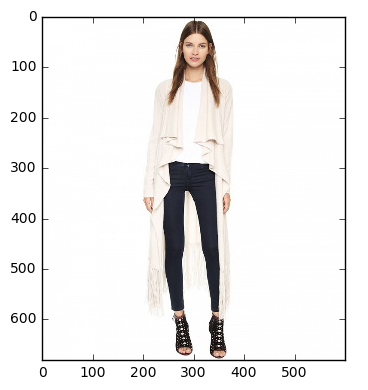

data/search_imgs\clothing-style-1.jpg


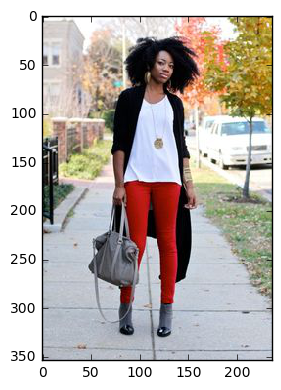

data/search_imgs\clothing-style-12.jpg


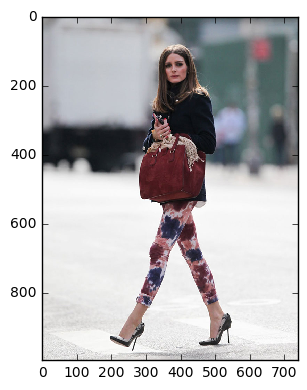

data/search_imgs\clothing-style-13.jpg


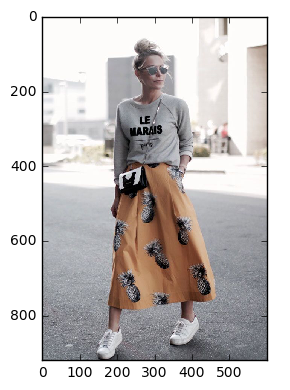

data/search_imgs\clothing-style-14.jpg


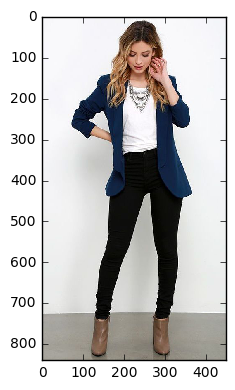

data/search_imgs\clothing-style-15.jpg


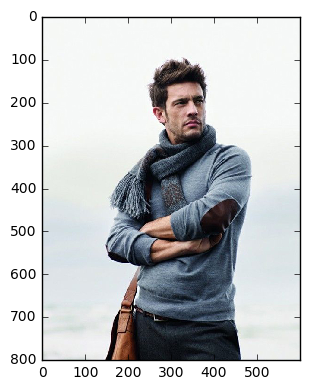

data/search_imgs\clothing-style-16.jpg


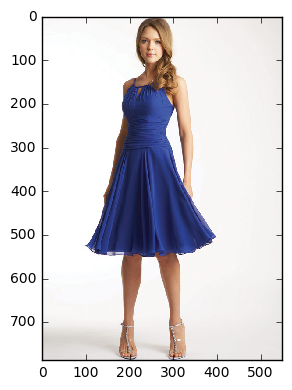

data/search_imgs\clothing-style-17.jpg


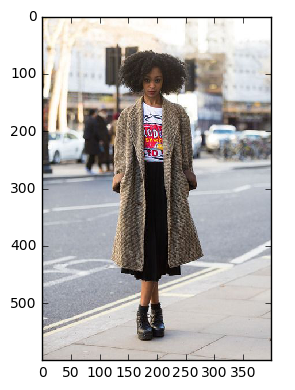

data/search_imgs\clothing-style-2.jpg


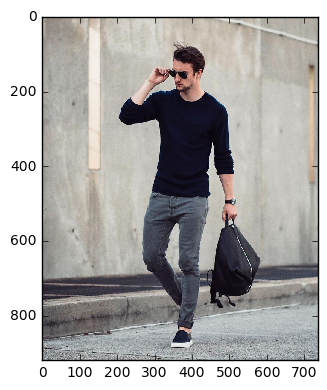

data/search_imgs\clothing-style-3.jpg


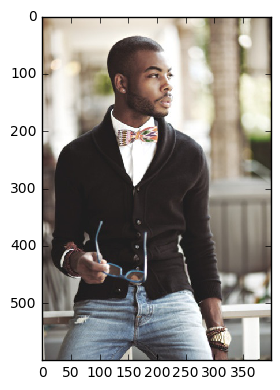

data/search_imgs\clothing-style-4.jpg


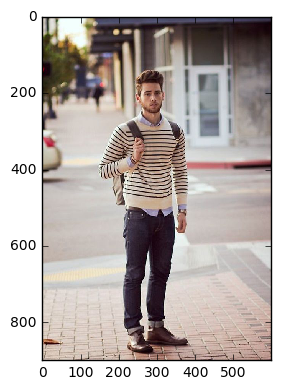

data/search_imgs\clothing-style-5.jpg


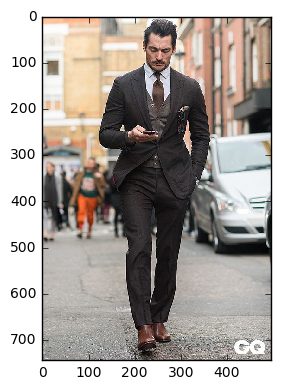

data/search_imgs\clothing-style-6.jpg


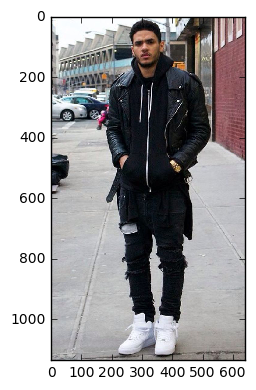

data/search_imgs\clothing-style-7.jpg


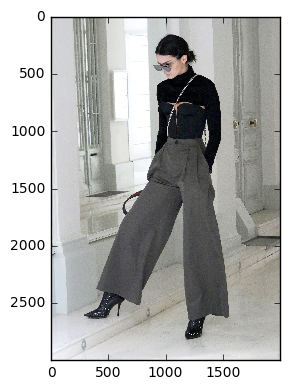

data/search_imgs\clothing-style-8.jpg


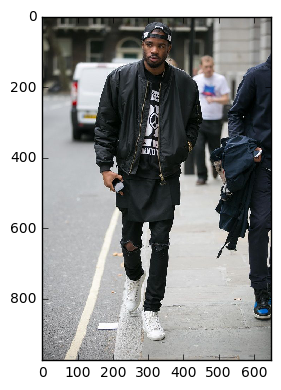

data/search_imgs\clothing-style-9.jpg


In [2]:
# load each image into a list
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from skimage import transform
import numpy as np
import glob

# make a function to preprocess each image
def preprocess_img(x):
    x = x[:,:,[2,1,0]]
    x[:,:,0] -= 103.939
    x[:,:,1] -= 116.779
    x[:,:,2] -= 123.68
    x = np.expand_dims(x, axis=0)
    return x

im_files = glob.glob('data/search_imgs/*')

search_imgs = []
search_imgs_orig = []
for im_path in im_files:
    img = imread(im_path)
    search_imgs_orig.append(img)
    imshow(img / 255.)
    plt.show()
    img = transform.resize(img, output_shape=(224, 224 , 3), preserve_range=True)
    print(im_path)
    img = preprocess_img(img)
    search_imgs.append(img)

### Extract the ConvNet features from each imge

Now that we have each image preprocessed and ready to go for a neural network we will push each image through the network and retrieve the subsequent vector representations. For each image instead of a 224x224x3 tensor of pixel values we will now have a 25088 length dense vector. Each value of the vector will represent the activation of a particular neuron. 

In [3]:
# make a list of the featurized imags
search_ims_feats = []
for im in search_imgs:
    search_ims_feats.append(model.predict(im).flatten())
    
print(search_ims_feats[0].shape)

(25088,)


### Load the query image

We will look for the image that most closely resembles this one in the search images. 

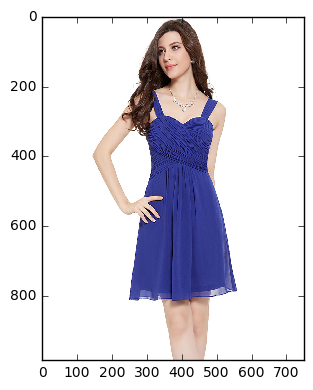

In [4]:
# get the query image
q_img = imread('data/query_img/query_dress.jpg')
imshow(q_img / 255.)
plt.show()
q_img = transform.resize(q_img, output_shape=(224, 224 , 3), preserve_range=True)

Preprocess the query image in the same way that we preprocessed the other images. Then get the vector representation of our query image. 

In [5]:
# prepross it and get the features
q_proc = preprocess_img(q_img)
q_vec = model.predict(q_proc).flatten()
print(q_vec.shape)

(25088,)


### Find the closest match to our query image

Now that we've got vector representations for our query and search images the only thing that we have to do to find the closet match is perform a distance metric between the query image and all of the search images. Each of our images is now represented by a 25088-dimensional vector so we will do all of the comparisons with a cosine distance. The image that has the lowest cosine distance from our query image should be the best match. 

6


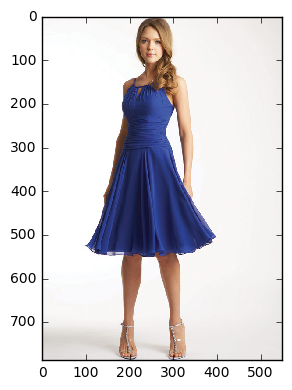

In [6]:
# compute the cosine distance between the query img and all of the others
from scipy import spatial

distances = []
for s_vec in search_ims_feats:
    distances.append(spatial.distance.cosine(q_vec, s_vec))
    
print(np.argmin(distances))

imshow(search_imgs_orig[np.argmin(distances)] / 255.)
plt.show()